# Penjelasan Dataset yang digunakan

1. Kasus yang Diambil

Dalam tugas kelompok ini, topik yang dianalisis adalah analisis sentimen terhadap aplikasi media sosial baru milik Meta, yaitu Threads. Aplikasi ini sempat menarik perhatian publik dan memperoleh popularitas dalam waktu singkat, namun kemudian menghadapi berbagai permasalahan, terutama terkait penurunan tingkat retensi serta menurunnya aktivitas pengguna.

Analisis ini berfokus pada pengumpulan dan pengolahan data teks yang berisi opini publik, seperti ulasan dan komentar pengguna di berbagai platform. Data diperoleh dari sumber terbuka seperti Kaggle, yang menyediakan kumpulan teks relevan untuk dianalisis.

Tujuan utama dari analisis sentimen ini adalah mengklasifikasikan opini pengguna ke dalam tiga kategori utama, yaitu positif, negatif, dan netral, sehingga dapat diperoleh gambaran umum mengenai pandangan masyarakat terhadap Threads**, baik dari segi fitur, kinerja aplikasi, maupun pengalaman pengguna (UX/UI) secara keseluruhan.

2. Penjelasan Setiap Kolom

Dataset ulasan pengguna Threads yang digunakan dalam analisis ini terdiri dari enam (6) kolom utama, di mana masing-masing kolom memiliki peran spesifik dalam proses Analisis Sentimen:

a. userName: berfungsi untuk mencatat nama pengguna (username) dari akun yang memberikan ulasan atau komentar. Data pada kolom ini penting untuk melacak sumber data ulasan di platform seperti Google Play Store atau App Store.

b. score: Kolom score berisi nilai rating numerik (biasanya dalam skala 1 hingga 5) yang diberikan pengguna terhadap aplikasi Threads. Nilai ini merupakan indikator kepuasan awal, di mana skor 4 atau 5 sering digunakan sebagai basis pelabelan sentimen Positif, sementara skor 1 atau 2 mengindikasikan sentimen Negatif.

c. at: Kolom at menyimpan informasi Tanggal dan Waktu (timestamp) kapan ulasan tersebut dipublikasikan. Data ini sangat berguna untuk analisis tren, memungkinkan peneliti untuk melihat bagaimana sentimen pengguna berubah dari waktu ke waktu, terutama setelah adanya pembaruan (update) aplikasi atau fitur baru.

d. content: Kolom content berisi teks ulasan asli (raw review text) yang ditulis langsung oleh pengguna. Karena data ini adalah input utama dan sering kali mengandung bahasa sehari-hari, slang, atau karakter non-standar, kolom ini akan menjadi fokus utama dalam tahap Data Text Pre-processing untuk dibersihkan dan dinormalisasi.

e. translated_content: Kolom ini memuat terjemahan dari kolom content ke dalam bahasa standar, yang biasanya merupakan hasil dari proses scraping atau pra-pemrosesan awal. translated_content digunakan untuk menyeragamkan bahasa ulasan jika data mentah (content) terdiri dari campuran bahasa yang berbeda, sehingga memudahkan proses pemodelan sentimen.

f. sentiment: Kolom sentiment berfungsi sebagai Target (Label) dari proyek ini. Kolom ini berisi klasifikasi akhir dari setiap ulasan, yang dikategorikan sebagai Positif, Negatif, atau Netral. Data pada kolom ini sangat krusial karena akan digunakan sebagai referensi kebenaran (ground truth) untuk melatih dan menguji performa model Analisis Sentimen yang dibangun.

Untuk keperluan analisis ini, kami hanya akan mempertahankan kolom content, at, score, dan userName. Kolom translated_content dan sentiment akan dihapus atau diabaikan karena kolom sentiment akan dibuat ulang secara manual berdasarkan kriteria skor, dan kolom translated_content tidak diperlukan karena analisis akan dilakukan pada teks asli (content).


In [42]:
# 3. Import library

# Import pustaka utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import emoji
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords, words
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from tqdm import tqdm
tqdm.pandas()
import joblib

In [18]:
# 4. Load data

df = pd.read_excel(r"Downloads/Threads_reviewapp.xlsx")

In [19]:
df.head()

,userName,score,at,content,translated_content,sentiment
0,Rahma Lusiana,3,2024-06-29 02:29:45,"- Durasi rekam suara dipanjangin kalo bisa, bi...",- The duration of the voice recording is exten...,positive
1,EBH Gomone,5,2024-07-15 18:20:13,Selalu tetap terhubung tersinkron dalam family...,"Always stay connected, synchronized in my fami...",positive
2,Dwi Andriani,5,2024-07-06 08:24:14,Alhamdulillah senang bisa gabung di trend dan ...,"Alhamdulillah, I'm happy to be able to join th...",positive
3,Alex Penyiar Oficial,5,2024-07-09 09:57:29,Setiap Manusia yang memiliki Jiwa Seni ia memi...,Every human being who has an artistic soul has...,positive
4,Agustinur M.H Saputri,5,2024-06-18 23:20:49,Hallo admin meta. Sejauh ini aplikasi threads ...,Hello meta admin. So far the threads applicati...,positive


In [20]:
# Hapus kolom 'replyContent' dan 'repliedAt' secara permanen
df.drop(columns=['translated_content', 'sentiment'], inplace=True)

In [21]:
df

,userName,score,at,content
0,Rahma Lusiana,3,2024-06-29 02:29:45,"- Durasi rekam suara dipanjangin kalo bisa, bi..."
1,EBH Gomone,5,2024-07-15 18:20:13,Selalu tetap terhubung tersinkron dalam family...
2,Dwi Andriani,5,2024-07-06 08:24:14,Alhamdulillah senang bisa gabung di trend dan ...
3,Alex Penyiar Oficial,5,2024-07-09 09:57:29,Setiap Manusia yang memiliki Jiwa Seni ia memi...
4,Agustinur M.H Saputri,5,2024-06-18 23:20:49,Hallo admin meta. Sejauh ini aplikasi threads ...
...,...,...,...,...
995,Rama Adhi Nugraha,2,2023-07-08 11:18:23,Mantap.....! Akan tetapi setiap saya login mes...
996,Hafiz Abdul Mateen,1,2023-07-08 02:24:09,Kok saya gak bisa upload foto langsung force c...
997,Ani Irmawaty,5,2023-07-24 07:29:49,berharap bisa ngesave foto yg diposting tanpa ...
998,Dhony W,2,2023-07-11 13:32:18,Kenapa nomor threads saya nggak muncul di prof...


# Data Understanding


# 1. Jumlah baris data:
   Total baris data: 1000
------------------------------

# 2. Panjang rata-rata setiap baris (kolom 'content'):
   Panjang karakter rata-rata ulasan: 130.90
------------------------------

# 3. Cek data duplikasi:
   Jumlah baris duplikat: 0
------------------------------

# 4. Cek data kosong (Missing Values):
userName          0
score             0
at                0
content           0
content_length    0
dtype: int64
------------------------------

# 5. Distribusi data:
   A. Distribusi Skor/Rating:


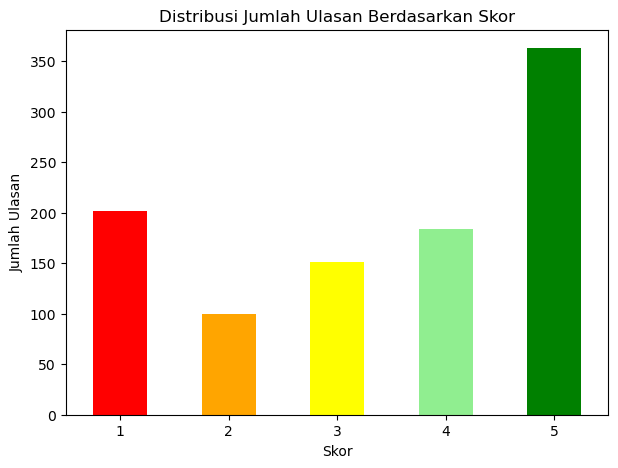


   B. Visualisasi Kata yang Sering Muncul (Word Cloud):


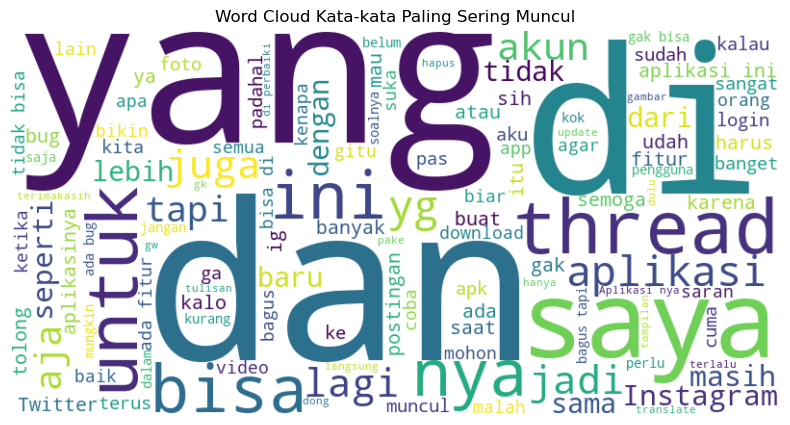

------------------------------

--- Contoh Lima Baris Data Teratas (df.head()) ---
                userName                                            content  \
0          Rahma Lusiana  - Durasi rekam suara dipanjangin kalo bisa, bi...   
1             EBH Gomone  Selalu tetap terhubung tersinkron dalam family...   
2           Dwi Andriani  Alhamdulillah senang bisa gabung di trend dan ...   
3   Alex Penyiar Oficial  Setiap Manusia yang memiliki Jiwa Seni ia memi...   
4  Agustinur M.H Saputri  Hallo admin meta. Sejauh ini aplikasi threads ...   

   score  content_length  
0      3             321  
1      5             180  
2      5             204  
3      5             490  
4      5             298  


In [25]:
# ==========================================================
# 1. Jumlah baris data
# ==========================================================
print("\n# 1. Jumlah baris data:")
jumlah_baris = len(df)
print(f"   Total baris data: {jumlah_baris}")
print("-" * 30)

# ==========================================================
# 2. Panjang rata-rata setiap baris (pada kolom 'content')
# ==========================================================
df['content_length'] = df['content'].astype(str).apply(len)
rata_rata_panjang = df['content_length'].mean()
print("\n# 2. Panjang rata-rata setiap baris (kolom 'content'):")
print(f"   Panjang karakter rata-rata ulasan: {rata_rata_panjang:.2f}")
print("-" * 30)

# ==========================================================
# 3. Cek data duplikasi
# ==========================================================
jumlah_duplikasi = df.duplicated().sum()
print("\n# 3. Cek data duplikasi:")
print(f"   Jumlah baris duplikat: {jumlah_duplikasi}")
if jumlah_duplikasi > 0:
    print(f"   Anda perlu menghapus duplikat menggunakan: df.drop_duplicates(inplace=True)")
print("-" * 30)

# ==========================================================
# 4. Cek data kosong (missing values)
# ==========================================================
print("\n# 4. Cek data kosong (Missing Values):")
data_kosong = df.isnull().sum()
print(data_kosong)
if data_kosong.any():
    print("   ⚠️ Terdapat data kosong. Perlu penanganan (drop atau imputasi).")
print("-" * 30)

# ==========================================================
# 5. Distribusi data menggunakan chart, seperti kata yang sering muncul.
# ==========================================================

print("\n# 5. Distribusi data:")

# A. Distribusi Skor (Bar Chart)
print("   A. Distribusi Skor/Rating:")
plt.figure(figsize=(7, 5))
df['score'].value_counts().sort_index().plot(kind='bar', color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('Distribusi Jumlah Ulasan Berdasarkan Skor')
plt.xlabel('Skor')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.show()

# B. Kata yang Sering Muncul (Word Cloud)
print("\n   B. Visualisasi Kata yang Sering Muncul (Word Cloud):")

# Gabungkan semua teks menjadi satu string tunggal
text_gabungan = " ".join(review for review in df.content.astype(str))

# Hasilkan Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=None, # Stopwords (kata umum) akan ditangani pada tahap Pre-processing
    min_font_size=10
).generate(text_gabungan)

# Tampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud Kata-kata Paling Sering Muncul')
plt.show()
print("-" * 30)

# ==========================================================
# Tambahan: Melihat contoh data
# ==========================================================
print("\n--- Contoh Lima Baris Data Teratas (df.head()) ---")
print(df[['userName', 'content', 'score', 'content_length']].head())

In [ ]:
## Data Text Processing

In [27]:
# 1. Tokenisasi
# 2. Lemmatization
# 3. Stemming
# 4. Stopword removal (Tanda baca, angka dan kata)
# 5. Text Normalisasi

from tqdm import tqdm
tqdm.pandas()
# Inisialisasi Sastrawi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

list_stopwords = stopwords.words('indonesian')

# Tambahkan kata-kata umum yang sering muncul di review
list_stopwords.extend(['yg', 'dg', 'karena', 'bgt', 'nya', 'nih', 'aja', 'saja', 'juga', 'buat', 'tlg', 'dgn'])

# Daftar kata tidak baku (Slang/Alay) untuk normalisasi
slang_dict = {
    'bgt': 'banget', 'oke': 'baik', 'tlg': 'tolong', 'puas': 'senang', 
    'ga': 'tidak', 'gak': 'tidak', 'kek': 'seperti', 'blm': 'belum'
}

# Fungsi Pre-processing yang akan diterapkan
def preprocess_text(text):
    # Case Folding
    text = text.lower()
    # Menghapus simbol, tanda baca, dan angka (No. 4)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenisasi (No. 1)
    tokens = text.split()
    
    # Text Normalisasi (No. 5)
    normalized_tokens = [slang_dict.get(word, word) for word in tokens]
    
    # Stopword Removal (No. 4 - kata)
    filtered_tokens = [word for word in normalized_tokens if word not in list_stopwords and len(word) > 1]
    
    # Stemming (No. 3)
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Lemmatization (No. 2 - Karena Sastrawi lebih fokus pada Stemming, 
    # di lingkungan Analisis Sentimen Indonesia, Stemming Sastrawi seringkali 
    # sudah mencakup tujuan Lemmatization yaitu mendapatkan bentuk dasar)
    
    return ' '.join(stemmed_tokens)

# Terapkan Pre-processing ke kolom content
df['content_processed'] = df['content'].apply(preprocess_text)

print("--- Hasil Pre-processing Teks ---")
print(df[['content', 'content_processed']].head())
print("-" * 50)

--- Hasil Pre-processing Teks ---
                                             content  \
0  - Durasi rekam suara dipanjangin kalo bisa, bi...   
1  Selalu tetap terhubung tersinkron dalam family...   
2  Alhamdulillah senang bisa gabung di trend dan ...   
3  Setiap Manusia yang memiliki Jiwa Seni ia memi...   
4  Hallo admin meta. Sejauh ini aplikasi threads ...   

                                   content_processed  
0  durasi rekam suara dipanjangin kalo biar posti...  
1  hubung sinkron family grup laman mudah cepat r...  
2  alhamdulillah senang gabung trend pakai trend ...  
3  manusia milik jiwa seni milik ide kreatif jiwa...  
4  hallo admin meta aplikasi threads bagus postin...  
--------------------------------------------------


In [30]:
# 7. Labeling data (Lexicon, Bert, atau polarity)
# Pelabelan Data Multi-Kelas (Positif, Negatif, Netral)
df_labeled = df.copy() # Gunakan seluruh data termasuk skor 3

def get_sentiment_label(score):
    if score >= 4:
        return 1  # Positif
    elif score <= 2:
        return 0  # Negatif
    else: # score == 3
        return 2  # Netral

df_labeled['sentiment_label'] = df_labeled['score'].apply(get_sentiment_label)

print("--- Hasil Pelabelan Data (Multi-Kelas) ---")
print(df_labeled[['content_processed', 'score', 'sentiment_label']])
print(f"\nDistribusi Label:\n{df_labeled['sentiment_label'].value_counts()}")
print("-" * 50)

--- Hasil Pelabelan Data (Multi-Kelas) ---
                                     content_processed  score  sentiment_label
0    durasi rekam suara dipanjangin kalo biar posti...      3                2
1    hubung sinkron family grup laman mudah cepat r...      5                1
2    alhamdulillah senang gabung trend pakai trend ...      5                1
3    manusia milik jiwa seni milik ide kreatif jiwa...      5                1
4    hallo admin meta aplikasi threads bagus postin...      5                1
..                                                 ...    ...              ...
995  mantap login mesti eror layar kyk hantam air s...      2                0
996       upload foto langsung force close tolong baik      1                0
997            harap ngesave foto diposting screenshot      5                1
998  nomor threads nggak muncul profil ig lambang t...      2                0
999                    keren sih update depan in fitur      5                1

[1000 ro

In [31]:
# 8. Text Vektorisasi
# 9. Data splitting dengan skala (0.8, 02)(0.9, 0.1)(0.75, 0.25)(0.85, 0.15) pilih salah satu dari beberapa skala yang ditentukan

# Text Vektorisasi (TF-IDF) - Sama seperti sebelumnya
X = df_labeled['content_processed']
y = df_labeled['sentiment_label']

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_vectorized = tfidf_vectorizer.fit_transform(X).toarray()

# Data Splitting (dengan kelas Netral)
test_size = 0.2 
random_state = 42 

# Pastikan parameter stratify=y digunakan agar pembagian kelas (0, 1, 2) proporsional
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=test_size, random_state=random_state, stratify=y
)

print("--- Hasil Data Splitting (Multi-Kelas) ---")
print(f"Data Latih (X_train) bentuk: {X_train.shape}")
print(f"Data Uji (X_test) bentuk: {X_test.shape}")
print(f"Proporsi Label di Data Latih:\n{y_train.value_counts(normalize=True)}")
print(f"Proporsi Label di Data Uji:\n{y_test.value_counts(normalize=True)}")
print("-" * 50)

--- Hasil Data Splitting (Multi-Kelas) ---
Data Latih (X_train) bentuk: (800, 1000)
Data Uji (X_test) bentuk: (200, 1000)
Proporsi Label di Data Latih:
sentiment_label
1    0.54750
0    0.30125
2    0.15125
Name: proportion, dtype: float64
Proporsi Label di Data Uji:
sentiment_label
1    0.545
0    0.305
2    0.150
Name: proportion, dtype: float64
--------------------------------------------------


--- 1. Pelatihan Model (Multinomial Naive Bayes) ---
   Model Multinomial Naive Bayes berhasil dilatih.
--------------------------------------------------
--- 2. Prediksi dan Evaluasi Model ---
   Akurasi Model pada Data Uji: 0.6700

   Classification Report:
              precision    recall  f1-score   support

     Negatif       0.70      0.52      0.60        61
     Positif       0.66      0.94      0.78       109
      Netral       0.00      0.00      0.00        30

    accuracy                           0.67       200
   macro avg       0.45      0.49      0.46       200
weighted avg       0.57      0.67      0.61       200


   Confusion Matrix:
 [[ 32  29   0]
 [  7 102   0]
 [  7  23   0]]


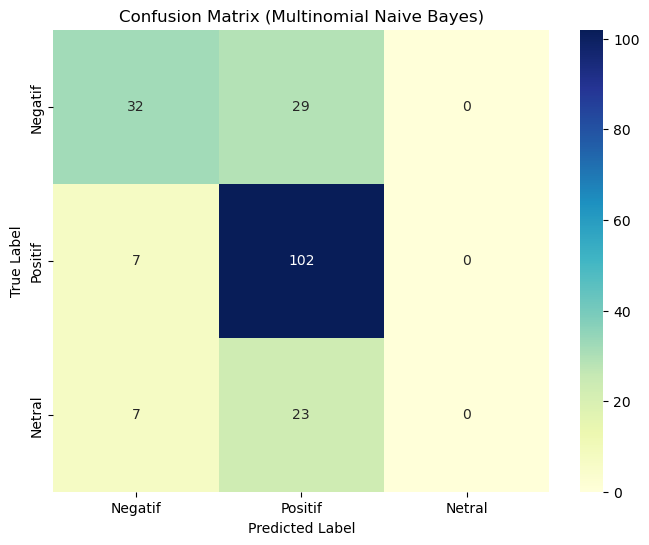

--------------------------------------------------


In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Asumsi: X_train, X_test, y_train, y_test sudah tersedia dari tahap sebelumnya (Vektorisasi & Splitting)
# X_train: Data latih yang sudah di-vektorisasi (TF-IDF)
# y_train: Label sentimen data latih (0, 1, 2 untuk Negatif, Positif, Netral)

# ==========================================================
# 1. Pelatihan Model (Multinomial Naive Bayes)
# ==========================================================

print("--- 1. Pelatihan Model (Multinomial Naive Bayes) ---")

# Inisialisasi model MNB
model_mnb = MultinomialNB()

# Melatih model
model_mnb.fit(X_train, y_train)
print("   Model Multinomial Naive Bayes berhasil dilatih.")
print("-" * 50)


# ==========================================================
# 2. Evaluasi Model
# ==========================================================

print("--- 2. Prediksi dan Evaluasi Model ---")

# Prediksi pada data uji
y_pred = model_mnb.predict(X_test)

# Menghitung Akurasi
akurasi = accuracy_score(y_test, y_pred)
print(f"   Akurasi Model pada Data Uji: {akurasi:.4f}")

# Classification Report (Presisi, Recall, F1-Score untuk setiap kelas)
print("\n   Classification Report:")
# Menggunakan target_names untuk multi-kelas (0=Negatif, 1=Positif, 2=Netral)
target_names = ['Negatif', 'Positif', 'Netral']
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n   Confusion Matrix:\n", cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Multinomial Naive Bayes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print("-" * 50)

# Data Prediksi

In [40]:

# ==========================================================
# PENGUJIAN MODEL 
# ==========================================================

print("\nTesting model Naive Bayes")
print("=" * 30)

# Data komentar baru yang akan diuji
komentar_baru = [
    "Aplikasinya buruk.", # Harusnya Negatif
    "Aplikasinya Bagus", # Harusnya Positif
    "Aplikasinya lumayan, tapi lambat agak lama.", # Harusnya Netral/Negatif
    "Apilkasinya keren, saya suka sekali!" # Harusnya Positif
]

# Bersihkan teks & gabungkan kembali ke string
komentar_baru_bersih = []
for k in komentar_baru:
    tokens_bersih = bersihkan_teks(k)
    komentar_bersih_str = ' '.join(tokens_bersih)
    komentar_baru_bersih.append(komentar_bersih_str)

print(f"Komentar bersih: {komentar_baru_bersih}")

# Transformasi ke TF-IDF (Gunakan transform)
X_baru = tfidf_vectorizer.transform(komentar_baru_bersih)

# Prediksi Sentimen
prediksi = model_mnb.predict(X_baru)


# Tampilkan hasil
def map_sentiment(label):
    if label == 1:
        return 'Positif'
    elif label == 0:
        return 'Negatif'
    else: 
        return 'Netral' 

print("\n# Tampilkan hasil")
for komentar, prediksi_label in zip(komentar_baru, prediksi):
    sentimen = map_sentiment(prediksi_label)
    print(f"Komentar: {komentar} -> Sentimen: {sentimen}")


Testing model Naive Bayes
Komentar bersih: ['aplikasi buruk', 'aplikasi bagus', 'aplikasi lumayan lambat', 'apilkasinya keren suka']

# Tampilkan hasil
Komentar: Aplikasinya buruk. -> Sentimen: Negatif
Komentar: Aplikasinya Bagus -> Sentimen: Positif
Komentar: Aplikasinya lumayan, tapi lambat agak lama. -> Sentimen: Netral
Komentar: Apilkasinya keren, saya suka sekali! -> Sentimen: Positif


In [45]:
# Simpan model ke file
joblib.dump(model_mnb, 'models/model_logistic_regression.pkl')

['models/model_logistic_regression.pkl']